# Climate stripes demonstrated in a notebook

If you already have these packages installed, then you should be able to get started without any installations:

In [53]:
!cat requirements.txt

convertbng
fsspec
kerchunk
mdpdf
xarray
numpy
matplotlib

If not, then you'll need to install them, usually with `pip`, as follows:

In [3]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 60.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 53.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 53.7 MB/s eta 0:00:0000:01:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


If you had to install the dependencies, then you should restart the kernel (with the button/option above, or by running this cell)...

In [54]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

We are ready to import the required libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import fsspec
from convertbng.util import convert_bng
import IPython
from IPython.display import Image

Since getting the data can take some time (approx. 20 seconds), we use a **global cache** to speed up making repeat requests when testing and editing the code.

In [2]:
# Define the cache as a dictionary
CACHE = {}

Create some functions to deal with colour maps.

In [3]:
# Define some global constants for the colour maps
DEFAULT_CMAP = "RdBu_r"
N_COLOURS = 20


def get_colour_map(cmap_name=DEFAULT_CMAP, n_colours=-1):
    """
    Return a colour map object based on colour map name and the number of colour bins.
    Set n_colours to -1 to get a continuous colour map.
    """
    args = [cmap_name]
    if n_colours > 1: 
        args.append(n_colours)

    cmap = plt.get_cmap(*args)
    cmap._init()
    return cmap


def rgba_to_hex(r, g, b, a=None):
    """
    Convert (red, green, blue, alpha) tuples and convert to a Hex string to represent the colour.
    """
    r, g, b = [int(i * 255) for i in (r, g, b)]
    return "#" + "".join([("0" + hex(i).split("x")[1])[-2:] for i in (r, g, b)])


def get_colours_lookup(cmap_name=DEFAULT_CMAP, n_colours=N_COLOURS): 
    """
    Based on a colour map and a number of requested colours, return a lookup dictionary of:
        - (red, green, blue): colour name
    """
    cmap = get_colour_map(cmap_name, n_colours)
    assert cmap.N == n_colours

    cols = [((r, g, b), f"colour_{(i + 1):02d}") for i, (r, g, b, a) in sorted(enumerate(cmap._lut))]
    print("NOTE: The last three rows are the colours for data low and high out-of-range values and for masked values.")
    return dict(cols)

Now let's define a class to create a stripes dataset and plot.

In [69]:
# First define some global constants
KERCHUNK_PATH = "haduk-grid1.json"
SPATIAL_PROXIMITY_THRESHOLD = 0.05
DEFAULT_REFERENCE_PERIOD = (1901, 2000)


class HadUKStripesMaker:
    """
    A class to create climate stripes for different locations.
    You can tweak:
       - the location
       - the time range
       - the time range of the reference period (used for the average value)
       - the colour map used
       - the number of colours used
       - the spatial threshold used for checking a grid box centre is near the requested location

    Use as follows:
    >>> stripes_maker = HadUKStripesMaker()
    >>> df = stripes_maker.create(51.23, -1.23, )
    >>> stripes_maker.show_plot()
    >>> strips_maker.show_table()

    To specify a time range and a different number of colours and a blue-green colour map:
    >>> stripes_maker.create(51.23, -1.23, n_colours=10, cmap_name="winter", time_range=(1950, 2010), 
               output_file="new-stripes.png")
    """

    def __init__(self, kerchunk_path=KERCHUNK_PATH, 
                spatial_threshold=SPATIAL_PROXIMITY_THRESHOLD,
                reference_period=DEFAULT_REFERENCE_PERIOD,
                cmap_name=DEFAULT_CMAP,
                n_colours=N_COLOURS):

        self.kerchunk_path = kerchunk_path
        self.spatial_threshold = spatial_threshold
        self.reference_period = reference_period
        self.cmap_name = cmap_name
        self.n_colours = n_colours

        self.latest_df = None
        self.latest_plot = None
        self.latest_request = None

    def _check_location_is_near(self, lat, lon, point_ds, ds):
        """
        Checks that selected eastings and northings (in BNG coordinates) are within the lat/lon threshold of
        the `lat` and `lon` requested by the user.
    
        Raises an exception if outside the acceptable threshold.
    
        Returns tuple of: (eastings, northings)
        """
        y = float(point_ds.projection_y_coordinate.values)
        x = float(point_ds.projection_x_coordinate.values)
        
        lat_diff = abs(float(ds.latitude.sel(projection_y_coordinate=y, projection_x_coordinate=x)) - lat)
        lon_diff = abs(float(ds.longitude.sel(projection_y_coordinate=y, projection_x_coordinate=x)) - lon)
    
        assert lat_diff < self.spatial_threshold, f"Lat diff is too big: {lat_diff}"
        assert lon_diff < self.spatial_threshold, f"Lon diff is too big: {lon_diff}"
    
        return (x, y)
        
    def _extract_time_series_at_location(self, lat, lon, years=None, ref_period=DEFAULT_REFERENCE_PERIOD):
        """
        Read the data from the data files.
        Return a dictionary containing keys:
            - temp_series: the extracted temperature series
            - demeaned_temp_series: the temperature series with the mean of the reference period subtracted
            - eastings: actual easting of grid box centre (British National Grid)
            - northings: actual northing of grid box centre (British National Grid)
            - lat: actual latitude of grid box centre
            - lon: actual longitude of grid box centre
        """
        # Create a mapper to load the data from Kerchunk
        compression = "zstd" if self.kerchunk_path.split(".")[-1].startswith("zst") else None
        mapper = fsspec.get_mapper("reference://", fo=self.kerchunk_path, target_options={"compression": compression})

        # Create an Xarray dataset that will read from the NetCDF data files
        print("opening kerchunk...need bigger arrays and specify duplicate coords and lat lon from each")
        ds = xr.open_zarr(mapper, consolidated=False, use_cftime=True, decode_timedelta=False)
    
        print("convert to northings, eastings...")
        requested_eastings, requested_northings = [i[0] for i in convert_bng(lon, lat)] 
     
        print("extract nearest grid point (with time subset if specified)...")
        start_year, end_year = (str(years[0]), str(years[1])) if years \
                                else (str(ds.time.min().dt.year.values), str(ds.time.max().dt.year.values))
        temp_series = ds.tas.sel(projection_y_coordinate=requested_northings, 
                                 projection_x_coordinate=requested_eastings,
                                 method="nearest").sel(time=slice(start_year, end_year))
    
        # Check the chosen location is near the requested location
        print("check data point is close enough to the requested location (within spatial threshold)...")
        actual_eastings, actual_northings = self._check_location_is_near(lat, lon, temp_series, ds)
    
        # Get mean over reference period
        print("calculate the mean over the reference period...")
        reference_mean = temp_series.sel(time=slice(str(ref_period[0]), str(ref_period[1]))).mean()
    
        # Construct content to return
        response = {
            "temp_series": temp_series.squeeze().compute(),
            "demeaned_temp_series": (temp_series - reference_mean).squeeze().compute(),
            "eastings": actual_eastings, "northings": actual_northings,
            "lat": float(ds.latitude.sel(projection_y_coordinate=actual_northings, projection_x_coordinate=actual_eastings)),
            "lon": float(ds.longitude.sel(projection_y_coordinate=actual_northings, projection_x_coordinate=actual_eastings))
        }
        print("Returning data objects...")
        return response

    def create(self, lat, lon, n_colours=N_COLOURS, cmap_name=DEFAULT_CMAP, time_range=None, 
               output_file="climate-stripes.png", range_buffer=0.2):
        """
        Creates both a plot and a dataset (as a `pandas DataFrame`) based on input requirements.
        
        NOTE: range_buffer can be modified to ensure that the colours are all within range of the cmap.
        Returns a `pandas.DataFrame` object.
        """
        self.cmap_name = cmap_name or self.cmap_name
        time_range = tuple(time_range) if time_range else time_range

        n_colours = n_colours if n_colours > 0 else self.n_colours
        args = (lat, lon, n_colours, cmap_name, range_buffer, time_range)

        # Use the cache if the request has already been made
        if args in CACHE.keys():
            print("Loading from cache...")
            data = CACHE[args]
        else:
            print("Loading from file...")
            resp = self._extract_time_series_at_location(lat, lon, time_range)
            years = resp["temp_series"].time.dt.year
        
            actual_values = resp["temp_series"].values
            stripes_data = resp["demeaned_temp_series"].values
            data = {"years": years, "actual_values": actual_values, "stripes_data": stripes_data}
            print("Saving to cache...")
            CACHE[args] = data

        self.latest_request = {
            "lat": lat, "lon": lon, "n_colours": n_colours,
            "cmap_name": cmap_name, "time_range": (time_range or (int(data["years"].min()), int(data["years"].max())))
        }
        
        print("Downloaded data...")
        # Unpack dictionary
        years, actual_values, stripes_data = data["years"], data["actual_values"], data["stripes_data"]
    
        print("Min and max:", stripes_data.min(), stripes_data.max())
    
        # Add a buffer around the lower and upper boundaries - to use only values within the colourmap
        normalised_data = plt.Normalize(stripes_data.min() - range_buffer, stripes_data.max() + range_buffer)
        cmap = get_colour_map(self.cmap_name, n_colours)
        
        fig, ax = plt.subplots(figsize=(10, 2))
        
        print("Starting plot")
    
        colours = []
        
        for i in range(stripes_data.shape[0]):
            actual_value = actual_values[i]
            year = years[i]
            normalised_value = normalised_data(stripes_data[i])
            rgba_colour = cmap(normalised_value)
            colours.append(rgba_colour)
    
            # collected.append([actual_value, normalised_value, colour])
            ax.axvspan(
                xmin=i - 0.5, xmax=i + 0.5, color=rgba_colour
            )
        
        ax.axis("off")
        plt.savefig(output_file)
        print(f"Saved image file: {output_file}")
        self.latest_plot = output_file

        df = pd.DataFrame({
            "years": years,
            "temp_value": actual_values,
            "temp_demeaned": stripes_data,
            "hex_colour": [rgba_to_hex(r, g, b) for (r, g, b, a) in colours],
            "red": [col[0] for col in colours],
            "green": [col[1] for col in colours],
            "blue": [col[2] for col in colours]
        })

        self.latest_df = self._extend_dataframe(df, cmap_name, n_colours)
        return self.latest_df

    def _extend_dataframe(self, df, cmap_name, n_colours):
        """
        Extends and returns the DataFrame with "colour_block" and "colour" columns.
        "colour_block" is empty - ready for highlighted rendering with `.show_table()`.
        """
        col_lookup = get_colours_lookup(cmap_name, n_colours)
        df["colour_block"] = ""
        df.loc[:, "colour"] = df.apply(lambda row: col_lookup[(row["red"], row["green"], row["blue"])], axis=1)
        return df

    def show_table(self, full=True):
        """
        Show the latest data table created.
        """
        print(f"Request details: {self.latest_request}")
        # gmap = np.array([self.latest_df.temp_demeaned]).transpose()
        # plt.rcParams["image.cmap"] = self.cmap_name
        # return df.style.background_gradient(axis=None, gmap=gmap, cmap=None, subset=['colour_block'])

        if full:
            df2 = self.latest_df.copy()
            df2["colour_block"] = ""
        else:
            df2 = pd.DataFrame(self.latest_df[["colour"]].value_counts().sort_values().sort_index())
            df2["colour_block"] = ""
            df2 = df2.reset_index()
        
        def _get_colour_mapping(df):
            tmp_df = df[["colour", "hex_colour"]].drop_duplicates().sort_values("colour")
            dct = pd.Series(tmp_df.hex_colour.values, index=tmp_df.colour).to_dict()
            return {key: f"background-color: {colour}" for key, colour in dct.items()}
                
        def _highlight_cols(df, full_df=self.latest_df):
            style_df = df.copy().astype(str)
            style_df.loc[:,:] = 'background-color: none'
            colour_dict = get_colour_mapping(full_df)
            style_df["colour_block"] = df.colour.map(colour_dict)
            return style_df
        
        return df2.style.apply(highlight_cols, axis=None)
    

    def show_plot(self):
        "Show the latest plot."
        print(f"Image location: {self.latest_plot}")
        return Image(self.latest_plot)
    
    def clear_cache(self):
        "Empties global cache dictionary."
        keys = list(CACHE.keys())

        for key in keys:
            del CACHE[key]

If you ever want to clear the cache, uncomment and run the following cell:

In [70]:
# stripes_maker = HadUKStripesMaker()
# stripes_maker.clear_cache()

## Start up the stripes maker

You can create many stripes datasets from this maker object.

In [71]:
stripes_maker = HadUKStripesMaker()

## Create stripes for the RAL location

```
RAL_LAT, RAL_LON = 51.570664384, -1.308832098
```

Loading from cache...
Downloaded data...
Min and max: -1.4422028892180654 1.9585098211170298
Starting plot
Saved image file: climate-stripes.png
NOTE: The last three rows are the colours for data low and high out-of-range values and for masked values.


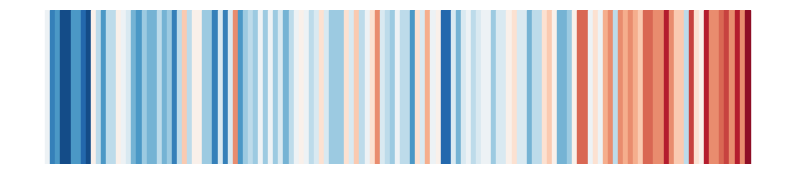

In [72]:
df = stripes_maker.create(51.570664384, -1.308832098)
#df = stripes_maker.create(51.23, -1.23, n_colours=10, cmap_name="winter", time_range=(1950, 2010), output_file="new-stripes.png")

## View the latest table

In [76]:
stripes_maker.show_table()

Request details: {'lat': 51.570664384, 'lon': -1.308832098, 'n_colours': 20, 'cmap_name': 'RdBu_r', 'time_range': (1884, 2022)}


,years,temp_value,temp_demeaned,hex_colour,red,green,blue,colour_block,colour
0,1884,9.443430,0.197319,#edf2f5,0.929412,0.950052,0.961404,,colour_10
1,1885,8.347185,-0.898927,#3480b9,0.206605,0.502167,0.726729,,colour_04
2,1886,8.463399,-0.782712,#4b98c5,0.295356,0.597110,0.775851,,colour_05
3,1887,7.902349,-1.343762,#134c88,0.077399,0.299690,0.535191,,colour_02
4,1888,7.862134,-1.383977,#134c88,0.077399,0.299690,0.535191,,colour_02
5,1889,8.484557,-0.761554,#4b98c5,0.295356,0.597110,0.775851,,colour_05
6,1890,8.366485,-0.879627,#4b98c5,0.295356,0.597110,0.775851,,colour_05
7,1891,8.093666,-1.152445,#2268ad,0.136429,0.409288,0.679257,,colour_03
8,1892,7.803908,-1.442203,#134c88,0.077399,0.299690,0.535191,,colour_02
9,1893,9.633320,0.387209,#f8efea,0.974819,0.939732,0.919092,,colour_11


In [77]:
stripes_maker.show_table(full=False)

Request details: {'lat': 51.570664384, 'lon': -1.308832098, 'n_colours': 20, 'cmap_name': 'RdBu_r', 'time_range': (1884, 2022)}


,colour,count,colour_block
0,colour_02,3,
1,colour_03,3,
2,colour_04,4,
3,colour_05,7,
4,colour_06,9,
5,colour_07,14,
6,colour_08,18,
7,colour_09,16,
8,colour_10,14,
9,colour_11,10,


## View the latest plot

Image location: climate-stripes.png


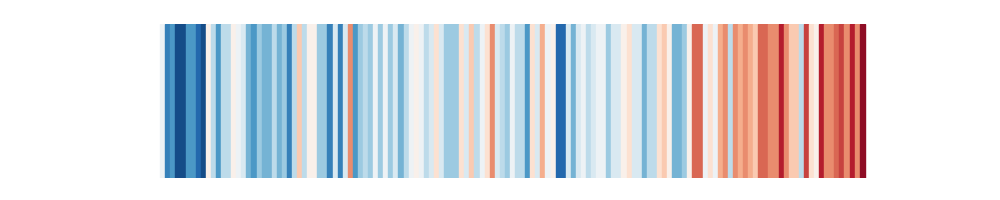

In [11]:
stripes_maker.show_plot()

## Appendices

### Appendix 1: Colour map definitions

You can define a colour map with unlimited (maybe 256 is the limit) colours, or specify your own limit, e.g.:

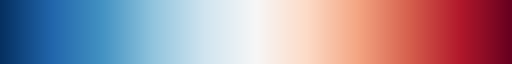

In [21]:
cmap = plt.get_cmap("RdBu_r")
cmap

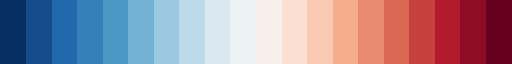

In [22]:
cmap = plt.get_cmap("RdBu_r", 20)
cmap

In [63]:
# df2 = pd.DataFrame(stripes_maker.latest_df[["colour"]].value_counts().sort_values().sort_index())
# df2["colour_block"] = ""
# df2 = df2.reset_index()

# def get_colour_mapping(df):
#     tmp_df = df[["colour", "hex_colour"]].drop_duplicates().sort_values("colour")
#     dct = pd.Series(tmp_df.hex_colour.values, index=tmp_df.colour).to_dict()
#     return {key: f"background-color: {colour}" for key, colour in dct.items()}
        

# def highlight_cols(df):
#     style_df = df.copy().astype(str)
#     style_df.loc[:,:] = 'background-color: none'
#     colour_dict = get_colour_mapping(stripes_maker.latest_df)
#     style_df["colour_block"] = df.colour.map(colour_dict)
#     return style_df    

# df2.style.apply(highlight_cols, axis=None)

,colour,count,colour_block
0,colour_02,3,
1,colour_03,3,
2,colour_04,4,
3,colour_05,7,
4,colour_06,9,
5,colour_07,14,
6,colour_08,18,
7,colour_09,16,
8,colour_10,14,
9,colour_11,10,
